In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split

import torchvision
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

import pytorch_lightning as pl
from pytorch_lightning import Trainer

from app.my_code.transform_class import ApplyTransform
from app.my_code.model import EmotionDetectionModel

%matplotlib inline

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# note that I am using pytorch_lightning version 0.7.6!
# if notebook throws an error, it's probably because of this mismatch
# if you want to change the version, run "pip install pytorch-lightning==0.7.6"
# afterwards, you can change it back to the current version with "pip install pytorch-lightning==1.3.8"
print(pl.__version__)

0.7.6


# I. Datasets and Dataloaders

### Create train, val and test dataset

In [4]:
from collections import Counter

def print_number_of_samples_per_class(dataset):
    distribution = dict(Counter(full_dataset.targets))
    for class_name, class_index in dataset.class_to_idx.items():
        print(f"class \"{class_name}\": {distribution[class_index]} samples")
    print(f"Total number of samples: {len(dataset)}")

In [5]:
repo_root = os.path.abspath(os.getcwd())
data_processed_dir = os.path.join(repo_root, "data_processed")

full_dataset = ImageFolder(root=data_processed_dir, transform=None)
print_number_of_samples_per_class(full_dataset)

class "angry": 502 samples
class "happy": 508 samples
class "sad": 497 samples
Total number of samples: 1507


In [6]:
split = {"train": 0.8, "val": 0.1, "test": 0.1}

train_size = int(split["train"] * len(full_dataset))
val_size = int(split["val"] * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_set, val_set, test_set = random_split(full_dataset, [train_size, val_size, test_size])
print(f"train_set: {len(train_set)} samples")
print(f"val_set: {len(val_set)} samples")
print(f"test_set: {len(test_set)} samples")

train_set: 1205 samples
val_set: 150 samples
test_set: 152 samples


### Apply transformations to each dataset

In [7]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

# note: dataset has already been pre-processed to consist of only images of faces of resolution 160x160
# this was done using the mtcnn_preprocessing.py file, which detected faces in images (of various resolutions)
# and cropped the images to these detected faces

# use data augmentation on train set
train_set_transform = T.Compose([
        T.RandomHorizontalFlip(p=0.5),
        T.RandomRotation(degrees=5),
        T.ColorJitter(brightness=.3, contrast=.2, hue=.2),
        T.GaussianBlur(kernel_size=3),
        T.ToTensor(),
        T.Normalize(mean=mean, std=std)
    ])

# don't use data augmentation on val and test set
val_test_set_transform = T.Compose([
        T.ToTensor(),
        T.Normalize(mean=mean, std=std)
    ])

# ApplyTransform is a custom class to apply the given transform to each set
train_set = ApplyTransform(train_set, train_set_transform)
val_set = ApplyTransform(val_set, val_test_set_transform)
test_set = ApplyTransform(test_set, val_test_set_transform)

### Create train, val and test dataloader

In [8]:
batch_size = 64

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

### Visualize some training samples

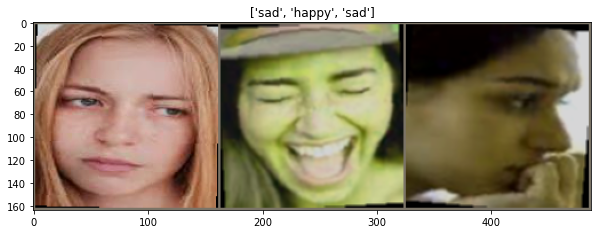

In [22]:
plt.rcParams['figure.figsize'] = (10,10) # Make the figures a bit bigger

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.array(std) * inp + np.array(mean)
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_loader))
class_names = full_dataset.classes

# Make a grid from batch
num_of_samples_to_show = 3

out = torchvision.utils.make_grid(inputs[:num_of_samples_to_show])

imshow(out, title=[class_names[x] for x in classes[:num_of_samples_to_show]])

# II. The Model

In [10]:
model = EmotionDetectionModel()

### Overfitting on a few samples (to see if model works)

In [11]:
trainer = pl.Trainer(weights_summary=None, max_epochs=15)

GPU available: False, used: False
No environment variable for node rank defined. Set as 0.


In [12]:
# create dataset consisting of 12 samples
overfit_transform = T.Compose([
        T.ToTensor(),
        T.Normalize(mean=mean, std=std)
    ])

overfit_dir = os.path.join(repo_root, "data_overfit")
overfit_dataset = ImageFolder(root=overfit_dir, transform=overfit_transform)
overfit_dataloader = DataLoader(overfit_dataset, batch_size=4, shuffle=True)
overfit_val_dataloader = DataLoader(overfit_dataset, batch_size=4, shuffle=False)

# train_dataloader and val_dataloader can be the same, since we just want to see the train loss go down (i.e. overfit)
trainer.fit(model, train_dataloader=overfit_dataloader, val_dataloaders=overfit_val_dataloader)

/Users/timtanida/opt/anaconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/Users/timtanida/opt/anaconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


/Users/timtanida/opt/anaconda3/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: Did not find hyperparameters at model hparams. Saving checkpoint without hyperparameters.
  warnings.warn(*args, **kwargs)


1

In [13]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs --port 6006

Reusing TensorBoard on port 6006 (pid 34208), started 3 days, 1:39:41 ago. (Use '!kill 34208' to kill it.)

### The loss is going down as expected (since we are overfitting on 12 samples) and the model recognizes different classes. This means we can start training the model with progressively more data.

![alt text](jupyter_files/overfit_loss.png "Overfit loss")

### Training the model on the full dataset

In [14]:
model = EmotionDetectionModel.load_from_checkpoint('my_models/model4/epoch=25-val_loss=0.36.ckpt')

In [15]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint

early_stop_callback = EarlyStopping(
   monitor='val_loss',
   patience=5,
   verbose=False,
   mode='max'
)

checkpoint_callback = ModelCheckpoint(
    filepath='my_models/model/{epoch}-{val_loss:.2f}',
    monitor='val_loss',
    save_top_k = 1,
    mode = 'min'
)

trainer = pl.Trainer(weights_summary=None, max_epochs=100, checkpoint_callback=checkpoint_callback, callbacks=[early_stop_callback])

GPU available: False, used: False
No environment variable for node rank defined. Set as 0.


In [16]:
model = EmotionDetectionModel() # optimizer has lr scheduler defined as ReduceLROnPlateau

In [17]:
trainer.fit(model, train_dataloader=train_loader, val_dataloaders=val_loader)

1

In [18]:
model = EmotionDetectionModel.load_from_checkpoint('my_models/model4/epoch=25-val_loss=0.36.ckpt')

### Final evaluation on test set

In [21]:
def compute_test_acc(model, test_loader):
    model.eval()

    preds = []
    labels = []
    angry = [] # has class label 0
    happy = [] # has class label 1
    sad = [] # has class label 2

    for batch in test_loader:
        images, targets = batch
        scores = model.forward(images)
        pred = scores.argmax(axis=1)
        pred = pred.detach().cpu().numpy()
        
        targets = targets.detach().cpu().numpy()
        
        preds.append(pred)
        labels.append(targets)
        
        # calculate accuracy per class
        
        for i, target in enumerate(targets):
            if target == 0: # if label is angry
                if pred[i] == target:
                    angry.append(1)
                else:
                    angry.append(0)
            elif target == 1: # if label is happy
                if pred[i] == target:
                    happy.append(1)
                else:
                    happy.append(0)
            else: # if label is sad
                if pred[i] == target:
                    sad.append(1)
                else:
                    sad.append(0)
                    
    print(f"Test accuracy of angry class: {np.array(angry).mean()}")
    print(f"Test accuracy of happy class: {np.array(happy).mean()}")
    print(f"Test accuracy of sad class: {np.array(sad).mean()}")

    preds = np.concatenate(preds, axis=0)
    labels = np.concatenate(labels, axis=0)

    acc = (labels == preds).mean()
    
    return acc
print(f"\nOverall test accuracy: {compute_test_acc(model, test_loader)}")

Test accuracy of angry class: 0.8444444444444444
Test accuracy of happy class: 0.9433962264150944
Test accuracy of sad class: 0.8518518518518519

Overall test accuracy: 0.881578947368421


### Test set accuracy of 88%! Not too bad for such a tiny dataset!